## Text Similarity Search
#### In this project, we will evaluate 3 similarity search methods, namely Cosine Similarity, Euclidean Distance, and Jaccard Similarity on text and image datasets

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


c:\Users\Jun Sheng\OneDrive\Desktop\SC4020-Project-1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "data\STSbenchmark.csv"
df = pd.read_csv(file_path)
df.head()

,sentence1,sentence2,score,score_binary
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00,1
1,A young child is riding a horse.,A child is riding a horse.,4.75,1
2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.00,1
3,A woman is playing the guitar.,A man is playing guitar.,2.40,0
4,A woman is playing the flute.,A man is playing a flute.,2.75,0


In [3]:
# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2') 

# Preprocess the dataframe to ensure sentences are strings
df['sentence1'] = df['sentence1'].apply(lambda x: str(x) if isinstance(x, str) else "")
df['sentence2'] = df['sentence2'].apply(lambda x: str(x) if isinstance(x, str) else "")

sentence1_embeddings = []
sentence2_embeddings = []

# Iterate through each row in the dataframe to compute embeddings
for index, row in df.iterrows():

    sentence1 = row['sentence1']
    sentence2 = row['sentence2']

    # Encode the sentences to get their embeddings
    sentence1_embedding = model.encode([sentence1], normalize_embeddings=True)
    sentence2_embedding = model.encode([sentence2], normalize_embeddings=True)

    # Append embeddings to lists
    sentence1_embeddings.append(sentence1_embedding[0])
    sentence2_embeddings.append(sentence2_embedding[0])


## Cosine Similarity

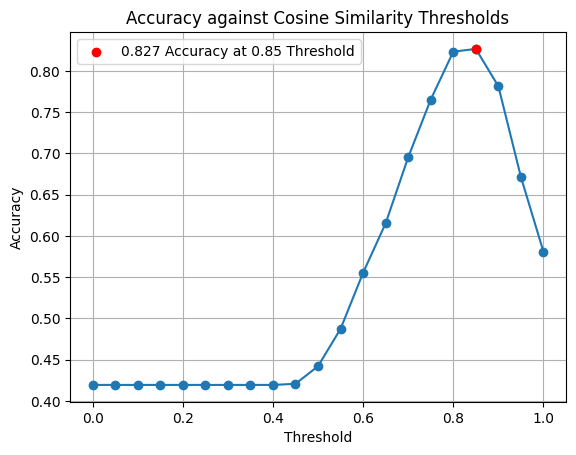

In [4]:
# Lists to store accuracy for each threshold
thresholds = []
accuracies = []

# Loop through thresholds from 0 to 1 with an increment of 0.05
for threshold in [i / 100 for i in range(0, 105, 5)]:

    # Compute cosine similarities for each pair of embeddings
    similarity_score = cosine_similarity(sentence1_embeddings, sentence2_embeddings)
    # Normalize similarity scores to range [0, 1]
    similarity_score = (similarity_score + 1) / 2

    # Loop through the DataFrame rows to populate the 'similarity' column
    for index in range(len(df)): 
        if similarity_score[index][index] > threshold: 
            df.at[index, 'similarity'] = 1 
        else:
            df.at[index, 'similarity'] = 0

    cm = confusion_matrix(df['score_binary'], df['similarity'])

    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)
    thresholds.append(threshold)

# Find the threshold with the highest accuracy
max_accuracy = max(accuracies)
max_accuracy_index = accuracies.index(max_accuracy)
best_threshold = thresholds[max_accuracy_index]

# Plotting the accuracy for different thresholds
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy against Cosine Similarity Thresholds')
plt.grid(True)
plt.scatter(best_threshold, max_accuracy, color='red', zorder=5, label=f'{max_accuracy:.3f} Accuracy at {best_threshold:.2f} Threshold')
plt.legend()
plt.show()

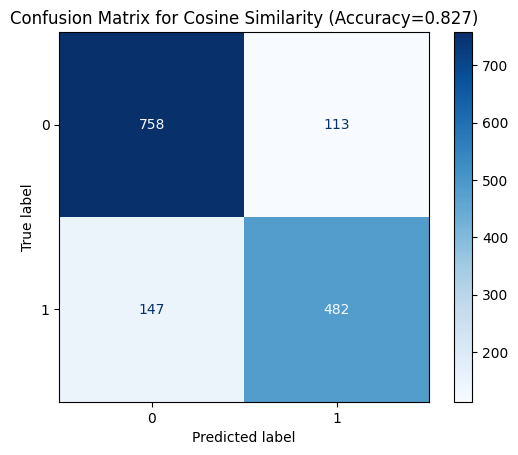

In [5]:
threshold = 0.85

# Compute cosine similarities for each pair of embeddings
similarity_score = cosine_similarity(sentence1_embeddings, sentence2_embeddings)
# Normalize similarity scores to range [0, 1]
similarity_score = (similarity_score + 1) / 2

# Loop through the DataFrame rows to populate the 'similarity' column
for index in range(len(df)): 
    if similarity_score[index][index] > threshold: 
        df.at[index, 'similarity'] = 1 
    else:
        df.at[index, 'similarity'] = 0

cm = confusion_matrix(df['score_binary'], df['similarity'])

TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Cosine Similarity (Accuracy={accuracy:.3f})')
plt.show()


In [6]:
# Filter rows where 'score_binary' and 'similarity' do not match
false_positives = df[(df['score_binary'] == 0) & (df['similarity'] == 1)]
false_negatives = df[(df['score_binary'] == 1) & (df['similarity'] == 0)]

# Combine both false positives and false negatives for investigation
false_cases = pd.concat([false_positives, false_negatives])

# Save the results to a CSV file
false_cases.to_csv("data/false_cases/cosine_similarity_false_cases.csv", index=False)
print("False positives and negatives saved to 'data/false_cases/cosine_similarity_false_cases.csv'")

False positives and negatives saved to 'data/false_cases/cosine_similarity_false_cases.csv'


## Euclidean Distance

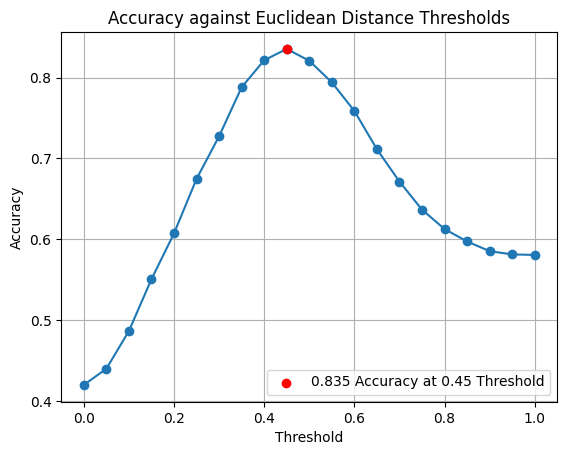

In [7]:
# List to store accuracy for each threshold
thresholds = []
accuracies = []

# Ensure that the embeddings are numpy arrays
sentence1_embeddings = np.array(sentence1_embeddings)
sentence2_embeddings = np.array(sentence2_embeddings)

# Loop through thresholds from 0 to 1 with an increment of 0.05
for threshold in [i / 100 for i in range(0, 105, 5)]:

    # Compute Euclidean distance between embeddings
    similarity = np.linalg.norm(sentence1_embeddings - sentence2_embeddings, axis=1)
    
    # Normalize similarity scores to range [0, 1]
    similarity_score = 1 - (similarity - similarity.min()) / (similarity.max() - similarity.min())

    # Loop through the DataFrame rows to populate the 'similarity' column
    for index in range(len(df)): 
        if similarity_score[index] > threshold: 
            df.at[index, 'similarity'] = 1 
        else:
            df.at[index, 'similarity'] = 0

    cm = confusion_matrix(df['score_binary'], df['similarity'])

    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)
    thresholds.append(threshold)

# Find the threshold with the highest accuracy
max_accuracy = max(accuracies)
max_accuracy_index = accuracies.index(max_accuracy)
best_threshold = thresholds[max_accuracy_index]

# Plotting the accuracy for different thresholds
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy against Euclidean Distance Thresholds')
plt.grid(True)
plt.scatter(best_threshold, max_accuracy, color='red', zorder=5, label=f'{max_accuracy:.3f} Accuracy at {best_threshold:.2f} Threshold')
plt.legend()
plt.show()

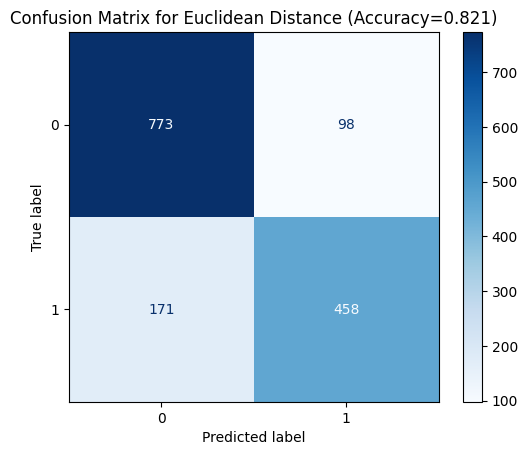

In [ ]:
threshold = 0.45

# Compute cosine similarities for each pair of embeddings
similarity = np.linalg.norm(sentence1_embeddings - sentence2_embeddings, axis=1)
# Normalize similarity scores to range [0, 1]
similarity_score = 1 - (similarity - similarity.min()) / (similarity.max() - similarity.min())

# Loop through the DataFrame rows to populate the 'similarity' column
for index in range(len(df)): 
    if similarity_score[index] > threshold: 
        df.at[index, 'similarity'] = 1 
    else:
        df.at[index, 'similarity'] = 0

cm = confusion_matrix(df['score_binary'], df['similarity'])

TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Euclidean Distance (Accuracy={accuracy:.3f})')
plt.show()

In [9]:
# Filter rows where 'score_binary' and 'similarity' do not match
false_positives = df[(df['score_binary'] == 0) & (df['similarity'] == 1)]
false_negatives = df[(df['score_binary'] == 1) & (df['similarity'] == 0)]

# Combine both false positives and false negatives for investigation
false_cases = pd.concat([false_positives, false_negatives])

# Save the results to a CSV file
false_cases.to_csv("data/false_cases/euclidean_distance_false_cases.csv", index=False)
print("False positives and negatives saved to 'data/false_cases/euclidean_distance_false_cases.csv'")

False positives and negatives saved to 'data/false_cases/euclidean_distance_false_cases.csv'


## Jaccard Similarity

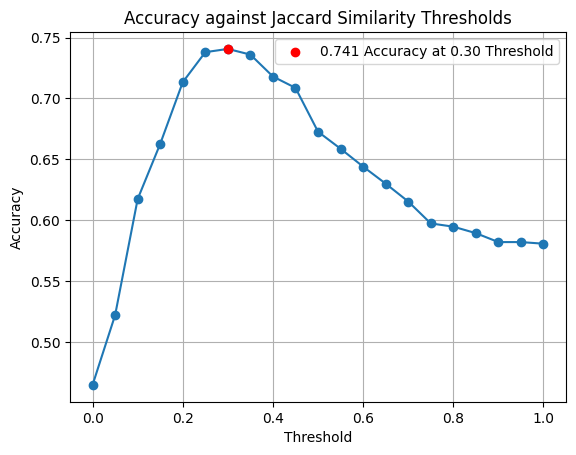

In [10]:
# List to store accuracy for each threshold
thresholds = []
accuracies = []

# Loop through thresholds from 0 to 1 with an increment of 0.05
for threshold in [i / 100 for i in range(0, 105, 5)]:
    
    # Loop through each row in the dataframe to compute Jaccard similarity
    for index, row in df.iterrows():

        sentence1 = row['sentence1']
        sentence2 = row['sentence2']

        # Convert sentences to sets of words
        set1 = set(sentence1.lower().split())
        set2 = set(sentence2.lower().split())

        # Compute Jaccard similarity
        similarity_score = len(set1.intersection(set2)) / len(set1.union(set2))

        # Populate the 'similarity' column based on the threshold
        if similarity_score > threshold:
            df.at[index, 'similarity'] = 1
        else:
            df.at[index, 'similarity'] = 0

    cm = confusion_matrix(df['score_binary'], df['similarity'])

    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)
    thresholds.append(threshold)

# Find the threshold with the highest accuracy
max_accuracy = max(accuracies)
max_accuracy_index = accuracies.index(max_accuracy)
best_threshold = thresholds[max_accuracy_index]

# Plotting the accuracy for different thresholds
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy against Jaccard Similarity Thresholds')
plt.grid(True)
plt.scatter(best_threshold, max_accuracy, color='red', zorder=5, label=f'{max_accuracy:.3f} Accuracy at {best_threshold:.2f} Threshold')
plt.legend()
plt.show()

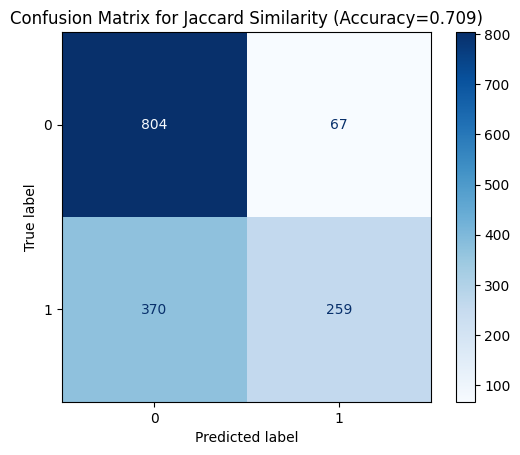

In [ ]:
threshold = 0.3

# Compute Jaccard similarity
for index, row in df.iterrows():

    sentence1 = row['sentence1']
    sentence2 = row['sentence2']

    # Convert sentences to sets of words
    set1 = set(sentence1.lower().split())
    set2 = set(sentence2.lower().split())

    # Compute Jaccard similarity
    similarity_score = len(set1.intersection(set2)) / len(set1.union(set2))

    # Populate the 'similarity' column based on the threshold
    if similarity_score > threshold:
        df.at[index, 'similarity'] = 1
    else:
        df.at[index, 'similarity'] = 0

cm = confusion_matrix(df['score_binary'], df['similarity'])

TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Jaccard Similarity (Accuracy={accuracy:.3f})')
plt.show()


In [12]:
# Filter rows where 'score_binary' and 'similarity' do not match
false_positives = df[(df['score_binary'] == 0) & (df['similarity'] == 1)]
false_negatives = df[(df['score_binary'] == 1) & (df['similarity'] == 0)]

# Combine both false positives and false negatives for investigation
false_cases = pd.concat([false_positives, false_negatives])

# Save the results to a CSV file
false_cases.to_csv("data/false_cases/jaccard_similarity_false_cases.csv", index=False)
print("False positives and negatives saved to 'data/false_cases/jaccard_similarity_false_cases.csv'")

False positives and negatives saved to 'data/false_cases/jaccard_similarity_false_cases.csv'
